In [52]:
import os 
import numpy as np
import json
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

In [2]:
os.chdir('../') # Change working directory to root repository path

# 1. Choose the model to test

In [81]:
name_data = '/mnt/archive/data/synthetic_data' # Replace with path of dataset
scheme = '64_points_3_shell'
snr_init = 20

result_path = os.path.join(name_data, scheme, '{0}_snr'.format(snr_init), 'gradients', 'result')

In [91]:
print('Available model: ')
for model in np.sort(os.listdir(result_path)):
    if 'history' in os.listdir(os.path.join(result_path, model)):
        n_epoch = len(os.listdir(os.path.join(result_path, model, 'history'))) - 1
        with open(os.path.join(result_path, model, 'args.txt')) as json_file:
            data = json.load(json_file)
        gm = bool(data['gm_path'])
        csf = bool(data['csf_path'])
        data_augm = bool(data['fodf_name'])
        shell = len(data['shell_list'].split(','))
        print(model, ': ', n_epoch, ' epoch(s) - ', 1 + gm + csf, ' tissue(s) - ', shell, ' shell(s) - ', 0 + data_augm, ' augmentation')

Available model: 
16_02_2021_04_14_40 :  6  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_04_40_15 :  10  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_05_25_54 :  4  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_05_40_07 :  1  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_05_45_42 :  1  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_05_51_31 :  -1  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_05_53_59 :  1  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_16_20_03 :  -1  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation
16_02_2021_16_21_02 :  29  epoch(s) -  3  tissue(s) -  4  shell(s) -  0  augmentation


# 2. Select model to test

In [92]:
model_name = '16_02_2021_16_21_02'
epoch = 29
model_path = os.path.join(result_path, model_name)
with open(os.path.join(model_path, 'args.txt')) as json_file:
    data = json.load(json_file)

root_path = data['root_path']
scheme = data['scheme']
snr = data['snr']

activation = data['activation']
normalization = data['normalization']
pooling = data['pooling']
filter_start = data['filter_start']
max_order = data['max_order']
interpolation = data['interpolation']
shell_list = data['shell_list']

gm = bool(data['gm_path'])
csf = bool(data['csf_path'])

fodf_name = bool(data['fodf_name'])
wm_in = data['wm_in']
gm_in = data['gm_in']
csf_in = data['csf_in']
mrtrix_input = data['mrtrix_input']
ind_path = data['ind_path']

# 3. Loss plot

In [93]:
loss_file = '{0}/{1}/{2}_snr/gradients/result/{3}/history/loss.pkl'.format(root_path, scheme, snr, model_name)
l = pkl.load(open(loss_file, 'rb'))

In [94]:
split = ['train', 'val']
loss_type = ['loss_intensity', 'loss_sparsity', 'loss_non_negativity_fodf', 'loss']
columns = ['split', 'epoch', 'loss_type', 'weighted_loss']
df = pd.DataFrame(columns=columns)
for s in split:
    l_split = l[s]
    n_epoch = list(l_split.keys())
    for e in n_epoch:
        if e>2:
            l_split_e = l_split[e]
            for t in loss_type:
                if t != 'loss':
                    w_loss = l_split_e[t]*l_split_e['weight_{0}'.format(t)]
                else:
                    w_loss = l_split_e[t]
                df2 = pd.DataFrame([[s, e, t, w_loss]], columns=columns)
                df = df.append(df2)

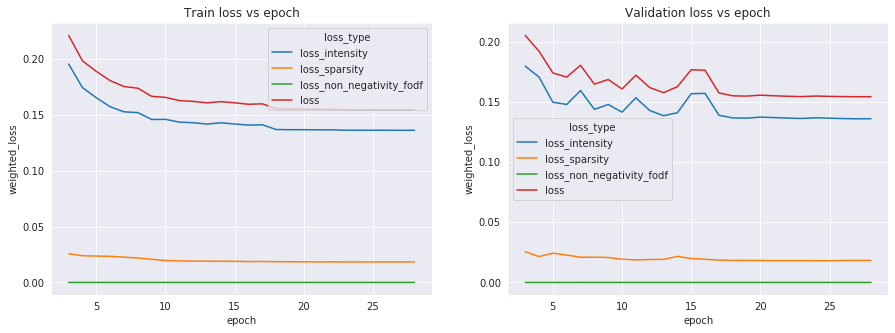

In [95]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=df[df['split']=='train'], x="epoch", y="weighted_loss", hue="loss_type")
plt.title('Train loss vs epoch')
plt.subplot(122)
sns.lineplot(data=df[df['split']=='val'], x="epoch", y="weighted_loss", hue="loss_type")
plt.title('Validation loss vs epoch')
plt.show()

# 4. Test the model

In [96]:
cmd = 'python model/test.py --root_path {0} --scheme {1} --snr {2} --shell_list {3} --epoch {4} --model_name {5}'.format(root_path, scheme, snr, shell_list, epoch, model_name)
cmd += ' --activation {0} --normalization {1} --pooling {2} --filter_start {3} --max_order {4} --interpolation {5}'.format(activation, normalization, pooling, filter_start, max_order, interpolation)
cmd += ' --fodf_name'*fodf_name + ' --wm_in'*wm_in + ' --gm_in'*gm_in + ' --csf_in'*csf_in + ' --mrtrix_input'*mrtrix_input
if ind_path:
    cmd += ' --ind_path {0}'.format(ind_path)
cmd += ' --gm '*gm + ' --csf '*csf
print(cmd)
os.system(cmd)

python model/test.py --root_path /mnt/archive/data/synthetic_data --scheme 64_points_3_shell --snr 20 --shell_list 0,1000,2000,3000 --epoch 29 --model_name 16_02_2021_16_21_02 --activation relu --normalization batch --pooling max --filter_start 8 --max_order 20 --interpolation sh --gm  --csf 


0